# GP Toolbox for DEAP

Here we use DEAP to implement GP. This notebook is based on the *DEAP Algorithms (GA)* notebook we used earlier and only does a **single** run to keep thing simple.

GP is a lot more complex than GA so we will import more packages and do a bit more housekeeping before we run out algorithm.

Install DEAP. 

In [48]:
!pip install deap

Import the DEAP tools and useful libraries . Notice this time we have some extra ones because of the symbolic nature of GP.

In [49]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

Set our Genetic Programming parameters.  Notice that these are virtually the same as the GA ones.

In [99]:
# Protected functions
# removed error handling as it was causing problems and changed it with if statement for protected division.
def protectedDiv(left, right):
    if (right==0):
      return 1
    return left / right
    


def psin(n):
    try:
        return numpy.sin(n)
    except Exception:
        return numpy.nan

def pcos(n):
    try:
        return numpy.cos(n)
    except Exception:
        return numpy.nan

def pow2(n):
    return operator.pow(n, 2)

###Snapshots of result with error handling instead of if statement

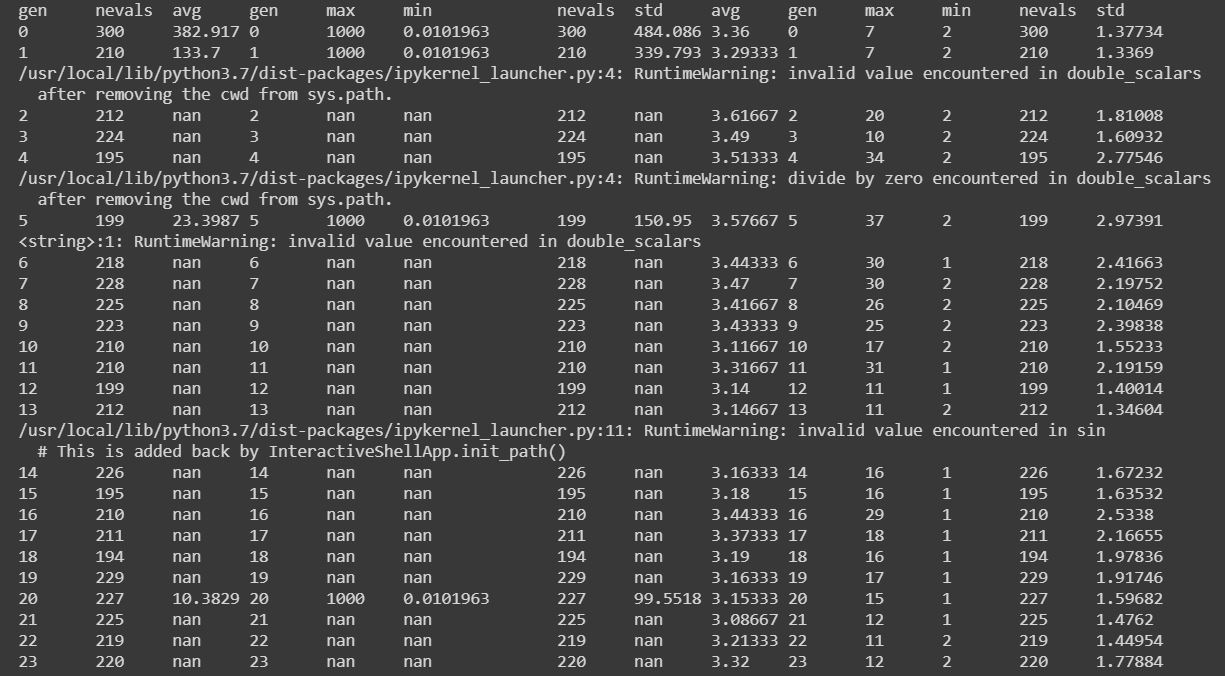

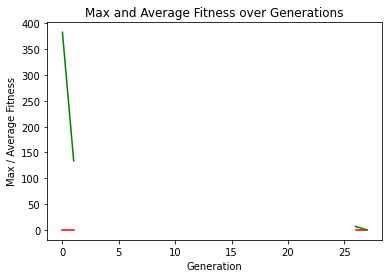

In [100]:
# Genetic Programming constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.7  # probability for crossover
P_MUTATION = 0.01   # probability for mutating an individual
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 10


Set the random seed. 

In [101]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

Because GP can mix and match operators and operands in an unconstrained way, we need to protect some our operators to prevent them from causing a crash.

Add our functions and terminals.

In [102]:
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(pcos, 1)
pset.addPrimitive(psin, 1)
pset.addPrimitive(pow2, 1)
pset.addPrimitive(numpy.exp,1)
pset.addEphemeralConstant("rand106", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

Define our fitness function. This one is a bit more involved than early examples for the GA, as we need to calculate the error. In this case we want to compare the returned (predicted) values from an individual compared to what **should** have been returned. If the error is huge (defined as > 1000 here), we put a ceiling of 1000 on it.


In [103]:
def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    #sqerrors = ((func(x) - x**6 - x**5 - x**4 - x**3 - x**2 - x)**2 for x in points) #change this fucntion
    #sqerrors = ((func(x) - x - 23)**2 for x in points)
    sqerrors = ((func(x)- ((math.exp(-1*x))*(x**3)*pcos(x)*psin(x)*((pcos(x)*(psin(x)**2))-1)))**2 for x in points)
    myError = math.fsum(sqerrors) / len(points)
    if myError>1000:
       myError=1000
    return myError,

Create our toolbox. We have a number of key differences here, so pay attention to the following:

* In this case (and usually with Symbolic Regression in GP) we are looking to **minimize** error
* Our individuals are **trees** rather than lists
* Some operators, e.g. mutation, operate differently for GP so take them from the gp package


In [104]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(5,1000)])
#toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-5,5)])
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Set up our population as before

In [105]:
population = toolbox.population(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)   


Create a statistics object. This time we're going to use the **MultiStatistics** tool because we want to record statistics about **size** as well as **fitness**.

In [106]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

Let's run our GP -- notice how it's almost the same as running the GA.

In [107]:
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                               ngen=MAX_GENERATIONS, stats=mstats,
                               halloffame=hof, verbose=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
<string>:1: RuntimeWarning: overflow encountered in exp


   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max 	min      	nevals	std    	avg 	gen	max	min	nevals	std    
0  	300   	382.917	0  	1000	0.0101963	300   	484.086	3.36	0  	7  	2  	300   	1.37734
1  	210   	133.7  	1  	1000	0.0101963	210   	339.793	3.29333	1  	7  	2  	210   	1.3369 
2  	212   	118.579	2  	1000	0.0101963	212   	321.402	3.61667	2  	20 	2  	212   	1.81008
3  	224   	40.0299	3  	1000	0.0101963	224   	195.558	3.46333	3  	10 	2  	224   	1.60062
4  	196   	23.4368	4  	1000	0.0101963	196   	150.944	3.35667	4  	8  	2  	196   	1.50647
5  	200   	20.0961	5  	1000	0.0101963	200   	139.987	3.55   	5  	18 	2  	200   	2.0052 
6  	217   	13.4107	6  	1000	0.0101963	217   	114.689	3.49667	6  	10 	2  	217   	1.54811
7  	231   	10.1084	7  	1000	0.0101963	231   	99.489 	3.56667	7  	21 	2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars


16 	215   	16.7051	16 	1000	0.0101963	215   	128.014	3.83333	16 	21 	2  	215   	2.11003
17 	201   	13.372 	17 	1000	0.0101963	201   	114.693	3.75333	17 	12 	2  	201   	1.66508
18 	211   	10.0334	18 	1000	0.0101963	211   	99.4955	3.87333	18 	23 	2  	211   	2.06009


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sin
  if sys.path[0] == '':


19 	221   	nan    	19 	nan 	nan      	221   	nan    	3.86333	19 	23 	2  	221   	2.32909
20 	223   	nan    	20 	nan 	nan      	223   	nan    	4.02667	20 	28 	2  	223   	2.7397 
21 	221   	nan    	21 	nan 	nan      	221   	nan    	4.15   	21 	28 	2  	221   	3.17398
22 	218   	10.7814	22 	1000	0.0101963	218   	100.298	4.09333	22 	23 	2  	218   	2.40512
23 	220   	6.68346	23 	1000	0.0101963	220   	81.3757	4.24333	23 	38 	2  	220   	3.32528
24 	228   	6.71048	24 	1000	0.0101963	228   	81.3746	4.07333	24 	36 	2  	228   	2.79785
25 	223   	13.3535	25 	1000	0.0101963	223   	114.695	4.07   	25 	36 	2  	223   	2.90834
26 	215   	6.69344	26 	1000	0.0101963	215   	81.3749	4.22333	26 	37 	2  	215   	3.08331


<string>:1: RuntimeWarning: invalid value encountered in double_scalars


27 	210   	nan    	27 	nan 	nan      	210   	nan    	4.38333	27 	37 	2  	210   	3.46839
28 	205   	6.69309	28 	1000	0.0101963	205   	81.3751	4.19667	28 	26 	2  	205   	2.39819
29 	221   	6.67778	29 	1000	0.0101963	221   	81.3761	4.19667	29 	38 	2  	221   	3.03721
30 	210   	nan    	30 	nan 	nan      	210   	nan    	3.99667	30 	25 	2  	210   	1.99916
31 	206   	10.0234	31 	1000	0.0101963	206   	99.4965	4.08   	31 	20 	2  	206   	1.90445
32 	220   	3.35016	32 	1000	0.0101963	220   	57.6378	3.99   	32 	15 	2  	220   	1.64212
33 	214   	3.3435 	33 	1000	0.0101963	214   	57.6381	3.85333	33 	9  	2  	214   	1.34851
34 	208   	6.68016	34 	1000	0.0101963	208   	81.376 	3.90667	34 	11 	2  	208   	1.3945 
35 	202   	6.67679	35 	1000	0.0101963	202   	81.3762	3.86333	35 	13 	2  	202   	1.38732
36 	210   	nan    	36 	nan 	nan      	210   	nan    	3.82667	36 	13 	2  	210   	1.39879


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in cos


37 	199   	nan    	37 	nan 	nan      	199   	nan    	3.81333	37 	19 	2  	199   	1.58487
38 	220   	0.0153546	38 	1.01249	0.0101963	220   	0.0656719	3.81667	38 	19 	2  	220   	1.55447
39 	200   	10.0101  	39 	1000   	0.0101963	200   	99.4977  	3.86   	39 	11 	2  	200   	1.25183
40 	214   	nan      	40 	nan    	nan      	214   	nan      	3.90667	40 	15 	2  	214   	1.64051
41 	220   	nan      	41 	nan    	nan      	220   	nan      	3.91333	41 	15 	2  	220   	1.57029
42 	214   	3.3435   	42 	1000   	0.0101963	214   	57.6381  	3.89333	42 	13 	2  	214   	1.37669
43 	188   	0.0101963	43 	0.0101963	0.0101963	188   	0        	3.88667	43 	9  	2  	188   	1.2886 
44 	233   	7.23981  	44 	1000     	0.0101963	233   	81.9107  	3.98333	44 	20 	2  	233   	1.87165
45 	231   	0.0101963	45 	0.0101963	0.0101963	231   	0        	3.77667	45 	19 	2  	231   	1.34169
46 	226   	3.34682  	46 	1000     	0.0101963	226   	57.638   	3.73333	46 	19 	2  	226   	1.33749
47 	224   	3.3435   	47 	1000     	0.0101963	224 

Extract our statistcs. This time our logbook has *chapters* because we have maintained multiple statistics.

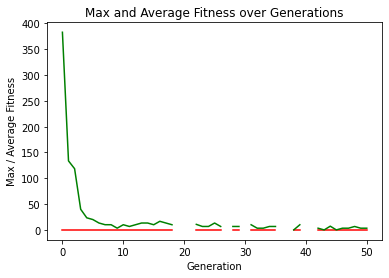

In [108]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

Not much evolution going on here for the max fitness, but that's okay as this is an easy problem. What's important is that we can see that the average fitness decreases quickly too.

In [109]:
print(max(maxFitnessValues))

0.010196275612814283


In [110]:
best = hof.items[0]
print("-- Best Individual = ", best)

-- Best Individual =  mul(0, pcos(pow2(sub(psin(protectedDiv(x, neg(0))), exp(pow2(x))))))
